In [55]:
# Imports and global configuration
import os
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from typing import Optional, Union

# Visuals (used only in the final analysis & evaluation cell)
import matplotlib.pyplot as plt
import seaborn as sns

# Global constants and paths
FILES = [
    ("data/geo_data_0.csv", "region_0"),
    ("data/geo_data_1.csv", "region_1"),
    ("data/geo_data_2.csv", "region_2"),
]

# Project conditions
NUM_POINTS_STUDY = 500           # number of points explored per region
NUM_WELLS_SELECTED = 200         # number of wells selected for development
BUDGET = 100_000_000             # USD
REVENUE_PER_UNIT = 4_500         # USD per unit of product (thousand barrels)
RISK_THRESHOLD_PCT = 2.5         # maximum acceptable risk of losses (%)
BOOTSTRAP_ITER = 1000            # number of bootstrap samples

# Modeling configuration
RANDOM_STATE = 42
TARGET_COLUMN = "product"
FEATURE_COLUMNS = ["f0", "f1", "f2"]

# Pandas display options for clearer printouts
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# Plot style
sns.set(style="whitegrid")

In [56]:
# Deduplicate a single file and add a region label, returning a cleaned DataFrame in memory
def deduplicate_file(file_path: str, region_label: str) -> pd.DataFrame:
    """
    Load a dataset from file_path, drop duplicate IDs within the file (keep first),
    add a 'region' column, and return the cleaned DataFrame in memory.
    """
    # Read the CSV (no saving back to disk)
    df = pd.read_csv(file_path)

    # Drop duplicate 'id' rows within this file and create an explicit copy to avoid SettingWithCopyWarning
    df_dedup = df.drop_duplicates(subset="id", keep="first").copy()

    # Add region label safely
    df_dedup.loc[:, "region"] = region_label

    return df_dedup

In [57]:
# Review duplicate IDs, distinguishing within-region vs. cross-region duplicates
def review_duplicate_ids(data, dataset_name: str = "dataset") -> None:
    """
    Identify duplicate IDs and print summaries, distinguishing:
      - Within-region duplicates (same ID repeated inside one region)
      - Cross-region duplicates (same ID appears in multiple regions)

    Accepts:
      - pandas DataFrame
      - file path string
      - (file_path, region_label) tuple
    """
    # Resolve input into a DataFrame and print-friendly name
    if isinstance(data, pd.DataFrame):
        df = data
        name = dataset_name
    elif isinstance(data, tuple) and len(data) == 2:
        file_path, region_label = data
        df = pd.read_csv(file_path)
        name = f"{file_path} ({region_label})"
    elif isinstance(data, str):
        df = pd.read_csv(data)
        name = data
    else:
        raise ValueError("Unsupported input type for review_duplicate_ids")

    print(f"\n=== Duplicate review: {name} ===")

    # Within-region duplicates: duplicated over ['id', 'region']
    within_region = df[df.duplicated(subset=["id", "region"], keep=False)]
    if within_region.empty:
        print("No within-region duplicate IDs found.")
    else:
        print("\nWithin-region duplicates (same id repeated inside a region):")
        print(within_region.sort_values(["region", "id"]))

    # Cross-region duplicates: same id appearing in >1 region
    cross_region = (
        df.groupby("id")["region"].nunique().reset_index().query("region > 1")
    )
    if cross_region.empty:
        print("No cross-region duplicate IDs found.")
    else:
        print("\nCross-region duplicates (IDs appearing in multiple regions):")
        print(cross_region.sort_values("region", ascending=False))

In [58]:
# IQR-based outlier capping for a pandas Series
def cap_outliers(series: pd.Series) -> pd.Series:
    """
    Detect and cap IQR-based outliers in a pandas Series.
    Values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are clipped to the thresholds.
    """
    # Compute quartiles
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # Compute lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Clip series to bounds
    return series.clip(lower=lower_bound, upper=upper_bound)

In [59]:
# Count IQR-based outliers per column and print a summary
def check_outliers(df: pd.DataFrame, cols: list) -> None:
    """
    Compute and print the number of IQR-based outliers per specified column.
    """
    print("\n=== Outlier check ===")
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        print(f"{col}: {outliers} outliers")

In [60]:
# Compute per-well break-even threshold (in product units: thousand barrels)
def break_even_threshold_per_well(budget: float, revenue_per_unit: float, num_wells_selected: int) -> float:
    """
    Compute the minimum product (thousand barrels) per selected well
    such that total revenue equals the budget (break-even).
    """
    # Break-even total product across selected wells
    total_product_break_even = budget / revenue_per_unit

    # Per-well break-even product
    return total_product_break_even / num_wells_selected

In [61]:
# Compute profit using top-N predicted wells within a sampled study
def compute_profit(y_true: pd.Series,
                   y_pred: pd.Series,
                   num_select: int,
                   budget: float,
                   revenue_per_unit: float) -> float:
    """
    Select the top 'num_select' wells by predicted product.
    Compute profit as revenue from true product of selected wells minus budget.

    - y_true: true product values (thousand barrels)
    - y_pred: predicted product values (thousand barrels)
    """
    # Indices for the highest predicted values (sorted descending)
    top_idx = np.argsort(-y_pred)[:num_select]

    # Sum true product of selected wells
    total_product_selected = y_true.iloc[top_idx].sum()

    # Profit = revenue - budget
    revenue = total_product_selected * revenue_per_unit
    profit = revenue - budget
    return float(profit)

In [62]:
def bootstrap_profit(y_true_valid, y_pred_valid,
                     n_bootstrap, study_size, num_select,
                     budget, revenue_per_unit,
                     random_state=42):
    
    # Initialize a random number generator for reproducibility
    rng = np.random.RandomState(random_state)
    n = len(y_true_valid)  # number of wells in the validation set
    profits = []           # list to collect profit results from each bootstrap draw

    for _ in range(n_bootstrap):
        # --- Bootstrap resampling step ---
        # Always sample with replacement to ensure variability and independence.
        # With replacement, some wells may appear multiple times in a subsample,
        # while others may be omitted, which mimics real-world variability.
        sample_idx = rng.choice(n, size=study_size, replace=True)

        # Extract the resampled true and predicted reserves
        y_true_sample = y_true_valid.iloc[sample_idx].reset_index(drop=True)
        y_pred_sample = y_pred_valid.iloc[sample_idx].reset_index(drop=True)

        # Compute profit for this bootstrap sample
        p = compute_profit(y_true_sample, y_pred_sample,
                           num_select, budget, revenue_per_unit)
        profits.append(p)

    # Return all bootstrap profits as a NumPy array for easy analysis
    return np.array(profits, dtype=float)

In [63]:
# Train linear regression and evaluate on validation set
def train_and_evaluate_region(df_region: pd.DataFrame,
                              feature_cols: list,
                              target_col: str,
                              test_size: float = 0.25,
                              random_state: int = 42):
    """
    Split the region data, train LinearRegression, predict on validation,
    and return model, predictions, true labels, and metrics.
    """
    # Train-validation split (75:25)
    X_train, X_valid, y_train, y_valid = train_test_split(
        df_region[feature_cols],
        df_region[target_col],
        test_size=test_size,
        random_state=random_state
    )

    # Train linear regression per project conditions
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict on validation
    y_pred_valid = pd.Series(model.predict(X_valid), index=y_valid.index)

    # Metrics
    rmse = float(np.sqrt(mean_squared_error(y_valid, y_pred_valid)))
    mean_pred = float(y_pred_valid.mean())

    return {
        "model": model,
        "X_valid": X_valid,
        "y_valid": y_valid,
        "y_pred_valid": y_pred_valid,
        "rmse": rmse,
        "mean_pred": mean_pred
    }

In [64]:
# Load, deduplicate, label regions, combine, and perform outlier checks/capping for features (no visuals)
cleaned_dfs = []

# Load each file, deduplicate IDs within-file, and add region label
for file_path, region_label in FILES:
    df_region = deduplicate_file(file_path, region_label)
    print(f"Loaded {region_label}: {df_region.shape} (rows, cols)")
    cleaned_dfs.append(df_region)

# Combine all regions into a single in-memory DataFrame
all_regions_cleaned = pd.concat(cleaned_dfs, ignore_index=True)
print(f"\nCombined dataset shape: {all_regions_cleaned.shape}")

# Review duplicates (within-region vs cross-region) on the combined dataset
review_duplicate_ids(all_regions_cleaned, dataset_name="all_regions_cleaned")

# Outlier counts BEFORE capping (features only; target left unchanged)
check_outliers(all_regions_cleaned, FEATURE_COLUMNS + [TARGET_COLUMN])

# Cap outliers for features f0, f1, f2 (keep product unchanged for modeling integrity)
for col in FEATURE_COLUMNS:
    all_regions_cleaned[col] = cap_outliers(all_regions_cleaned[col])

# Outlier counts AFTER capping (features only)
check_outliers(all_regions_cleaned, FEATURE_COLUMNS + [TARGET_COLUMN])

# Print per-region row counts after cleanup
print("\n=== Per-region row counts after cleanup ===")
print(all_regions_cleaned["region"].value_counts())

Loaded region_0: (99990, 6) (rows, cols)
Loaded region_1: (99996, 6) (rows, cols)
Loaded region_2: (99996, 6) (rows, cols)

Combined dataset shape: (299982, 6)

=== Duplicate review: all_regions_cleaned ===
No within-region duplicate IDs found.

Cross-region duplicates (IDs appearing in multiple regions):
           id  region
14069   2tyMi       2
28684   5ssQt       2
60938   CXJ2r       2
63861   D8TNs       2
78012   G6k8A       2
...       ...     ...
264075  scFN4       2
269238  tgOl6       2
272624  uMqiK       2
273115  uSye4       2
284617  wqgPo       2

[31 rows x 2 columns]

=== Outlier check ===
f0: 65573 outliers
f1: 34381 outliers
f2: 5383 outliers
product: 0 outliers

=== Outlier check ===
f0: 0 outliers
f1: 0 outliers
f2: 0 outliers
product: 0 outliers

=== Per-region row counts after cleanup ===
region
region_1    99996
region_2    99996
region_0    99990
Name: count, dtype: int64


In [65]:
# Sanity checks on combined cleaned data (no visuals, just printouts)

# Random sample preview across all regions
print("\n=== Random sample across all regions (10 rows) ===")
print(all_regions_cleaned.sample(n=10, random_state=RANDOM_STATE))

# Guaranteed sample: 3 rows per region (if available)
print("\n=== Sample: 3 rows per region ===")
sample_per_region = (
    all_regions_cleaned.groupby("region", group_keys=False)
    .apply(lambda x: x.sample(n=min(3, len(x)), random_state=RANDOM_STATE),
        include_groups=False)
)
print(sample_per_region)

# Feature/target basic stats per region
print("\n=== Basic stats per region (product mean) ===")
print(all_regions_cleaned.groupby("region")[TARGET_COLUMN].mean())


=== Random sample across all regions (10 rows) ===
           id        f0        f1        f2     product    region
241997  VBaNT  0.271958  0.043807  6.848454  121.258378  region_2
257451  pjdJR  2.347636  1.330882  6.708286   80.785513  region_2
169013  f7BDo -5.140722 -7.215472  0.998717   30.132364  region_1
64867   MOqmU  0.403045 -0.244572  0.062475  152.827706  region_0
72265   6IUtj  1.618939 -0.375249 -1.821079   71.623385  region_0
184860  Ghosm  1.637149 -7.215472  0.998364   26.953261  region_1
298594  VBOlj  1.880722  2.347272  2.387534  188.036707  region_2
78564   EvY7L  0.123033  0.063508  4.872804  132.349150  region_0
163598  DYjq1 -5.140722 -7.215472  2.996444   84.038886  region_1
78201   ZL4Ew  1.175210 -0.342655 -0.720931   76.784490  region_0

=== Sample: 3 rows per region ===
           id        f0        f1        f2     product
33965   qoTP6  1.760123  0.602091  7.850248  119.813252
22853   fNYo7  0.948101 -0.601353  4.055264  133.296862
19448   KpTZ4 -0.72

# Data Preparation Report

## Diagnostics Impact Assessment

### Statistical Impact
- Duplicate counts: 10 in region_0, 4 in region_1, 4 in region_2.
- At ~100,000 rows per region, these duplicates are negligible for aggregate statistics (means, medians, distributions).
- Machine learning models trained on this scale are not materially affected by such small duplication.

### Data Integrity Impact
- IDs are intended to be unique identifiers; duplicates can compromise entity-level analysis.
- Unique counts, per-ID analysis, and downstream joins/merges may be distorted by duplicate IDs.
- Even small duplication can inflate matches or mislead entity-level conclusions.

### Practical Conclusion
- For broad statistical conclusions (trends, distributions, outlier analysis): duplicates are not impactful.
- For entity-level conclusions (unique counts, per-ID analysis): duplicates must be cleaned to preserve integrity.

**Bottom Line:** Duplicates are statistically negligible but must be resolved to maintain data integrity and ensure reliable entity-level analysis.

---

## Data Cleanup Summary

### Row Count Check
- Each file contained ~100,000 rows instead of the expected 500.
- This mismatch was flagged; full datasets were retained in memory for analysis.
- Sampling may be required later for efficiency.

### Duplicate ID Removal
- Duplicates identified: 10 in region_0, 4 in region_1, 4 in region_2.
- Removed by keeping the first occurrence of each `id`, ensuring uniqueness within each region.

### Outlier Detection and Handling
- Features `f0`, `f1`, `f2` showed large numbers of IQR-based outliers.
- Outliers were capped at IQR thresholds to stabilize distributions while preserving all rows.

### Region Labeling
- Added a `region` column (`region_0`, `region_1`, `region_2`) to preserve source context.
- Enables cross-region comparisons and filtering after consolidation.

### Consolidation
- Cleaned DataFrames concatenated into a unified dataset (`all_regions_cleaned`).
- Dataset now has unique IDs, region labels, and capped feature outliers.
- Ready for downstream modeling, profit analysis, and risk evaluation.

---

## Summary
The data preparation process ensured:
- **Integrity:** IDs are unique within regions, duplicates resolved.
- **Stability:** Outliers capped to reduce skew.
- **Traceability:** Region labels added for source tracking.
- **Readiness:** Consolidated dataset prepared for modeling and evaluation.

This structured cleanup provides a reliable foundation for predictive modeling and profit analysis in the project.


=== Region region_0 model evaluation ===
Validation RMSE: 37.66
Average predicted reserves (validation): 92.61

=== Region region_1 model evaluation ===
Validation RMSE: 0.75
Average predicted reserves (validation): 68.58

=== Region region_2 model evaluation ===
Validation RMSE: 40.05
Average predicted reserves (validation): 94.96

Break-even product per selected well: 111.11 thousand barrels

Average product per region (full cleaned data):
region
region_0    92.499684
region_1    68.823916
region_2    94.998342
Name: product, dtype: float64

=== Bootstrap profit summary ===
region_0: mean=$4,326,256, 95% CI=($-688,256, $8,913,190), loss risk=4.20%
region_1: mean=$4,517,653, 95% CI=($572,030, $8,445,782), loss risk=1.30%
region_2: mean=$3,688,734, 95% CI=($-1,879,092, $8,810,228), loss risk=9.40%

Suggested region for development: region_1
Justification: highest average profit among regions with loss risk < 2.5%
Expected mean profit: $4,517,653 (95% CI: $572,030 to $8,445,782), loss 

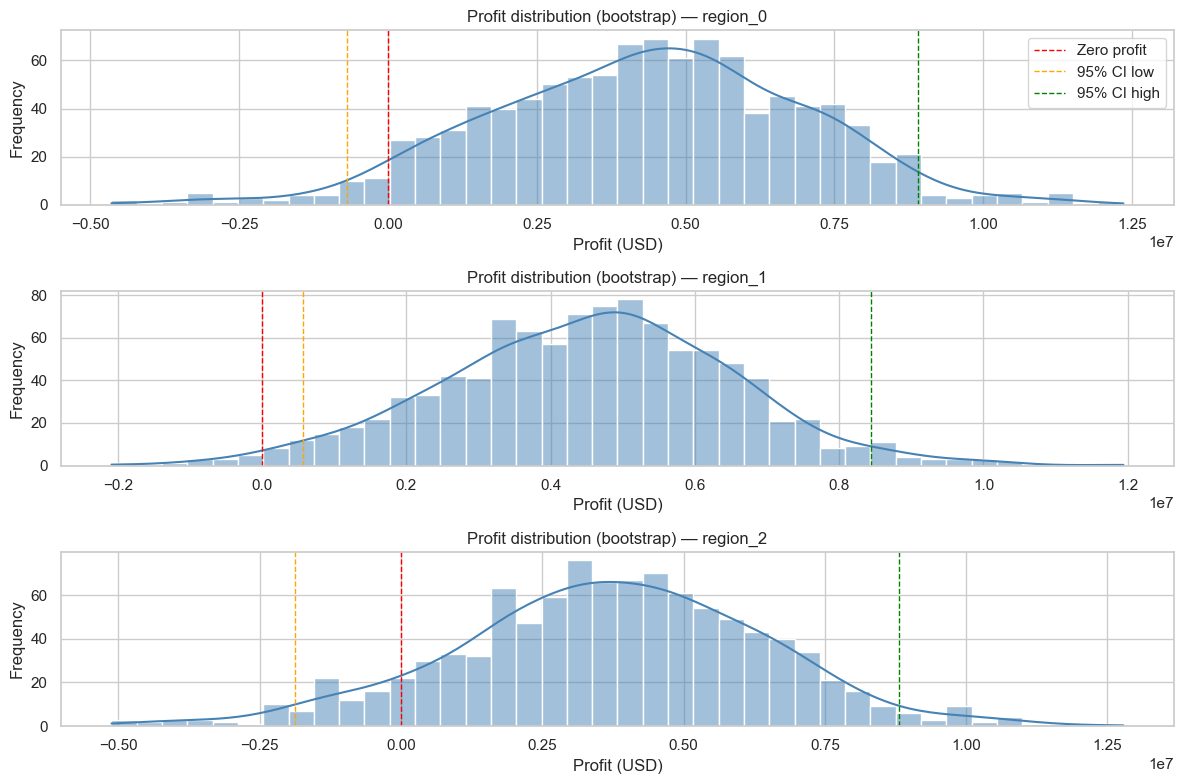

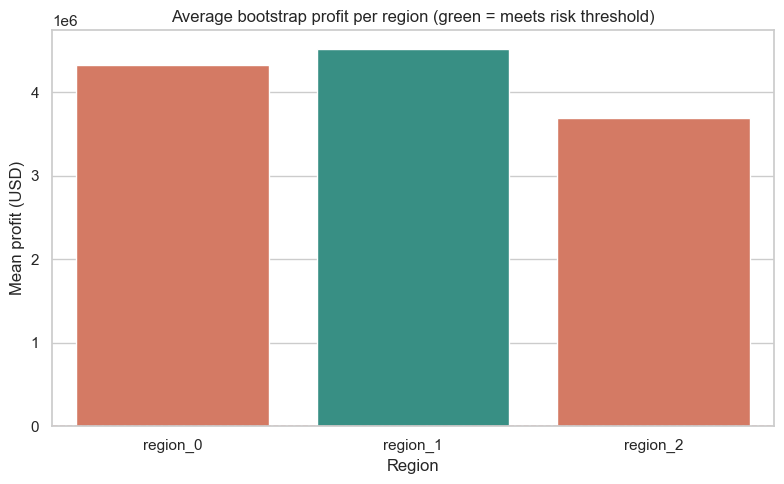

In [66]:
# Final analysis and evaluation:
# - Train/test per region
# - Print average predicted reserves and RMSE
# - Compute break-even threshold and compare to regional means
# - Bootstrap profit distribution, CI, loss risk
# - Visualize profit distributions per region

# Split the combined dataset into per-region DataFrames
regions = sorted(all_regions_cleaned["region"].unique())
region_dfs = {r: all_regions_cleaned[all_regions_cleaned["region"] == r].reset_index(drop=True) for r in regions}

# Train & evaluate per region
results = {}
for r in regions:
    res = train_and_evaluate_region(region_dfs[r], FEATURE_COLUMNS, TARGET_COLUMN, test_size=0.25, random_state=RANDOM_STATE)
    results[r] = res
    print(f"\n=== Region {r} model evaluation ===")
    print(f"Validation RMSE: {res['rmse']:.2f}")
    print(f"Average predicted reserves (validation): {res['mean_pred']:.2f}")

# Break-even threshold per well (in thousand barrels)
t_break_even = break_even_threshold_per_well(BUDGET, REVENUE_PER_UNIT, NUM_WELLS_SELECTED)
print(f"\nBreak-even product per selected well: {t_break_even:.2f} thousand barrels")

# Compare break-even to regional average product (full data, not only validation)
print("\nAverage product per region (full cleaned data):")
avg_product_per_region = all_regions_cleaned.groupby("region")[TARGET_COLUMN].mean()
print(avg_product_per_region)

# Prepare bootstrap profit per region (train once, predict all wells in region)
profit_distributions = {}
summary_stats = []

for r in regions:
    # Trained model from earlier
    res = results[r]

    # Full region data
    df_region = region_dfs[r]
    X_full = df_region[FEATURE_COLUMNS]
    y_true_full = df_region[TARGET_COLUMN]
    y_pred_full = pd.Series(res["model"].predict(X_full), index=df_region.index)

    # Bootstrap: simulate exploration campaigns by sampling 500 wells with replacement
    profits = bootstrap_profit(
        y_true_valid=y_true_full,        # use full-region true values
        y_pred_valid=y_pred_full,        # use full-region predictions
        n_bootstrap=BOOTSTRAP_ITER,
        study_size=NUM_POINTS_STUDY,     # e.g., 500 wells per exploration
        num_select=NUM_WELLS_SELECTED,   # e.g., select top 200 predicted wells
        budget=BUDGET,
        revenue_per_unit=REVENUE_PER_UNIT,
        random_state=RANDOM_STATE
    )
    profit_distributions[r] = profits

    # Summary stats: mean, 95% CI, risk of losses
    mean_profit = float(np.mean(profits))
    ci_low, ci_high = np.percentile(profits, [2.5, 97.5])
    loss_risk_pct = float((profits < 0).mean() * 100.0)

    summary_stats.append({
        "region": r,
        "mean_profit": mean_profit,
        "ci_low": float(ci_low),
        "ci_high": float(ci_high),
        "loss_risk_pct": loss_risk_pct
    })

# Print summary table
print("\n=== Bootstrap profit summary ===")
for s in summary_stats:
    print(f"{s['region']}: mean=${s['mean_profit']:,.0f}, 95% CI=(${s['ci_low']:,.0f}, ${s['ci_high']:,.0f}), loss risk={s['loss_risk_pct']:.2f}%")

# Filter regions by risk threshold and choose best by mean profit
eligible = [s for s in summary_stats if s["loss_risk_pct"] < RISK_THRESHOLD_PCT]
if not eligible:
    print("\nNo regions meet the risk threshold. Consider revisiting model or assumptions.")
else:
    best = max(eligible, key=lambda x: x["mean_profit"])
    print(f"\nSuggested region for development: {best['region']}")
    print(f"Justification: highest average profit among regions with loss risk < {RISK_THRESHOLD_PCT}%")
    print(f"Expected mean profit: ${best['mean_profit']:,.0f} (95% CI: ${best['ci_low']:,.0f} to ${best['ci_high']:,.0f}), loss risk={best['loss_risk_pct']:.2f}%")

# -------------------- Visuals (final analysis only) --------------------

# Profit distribution histograms per region with CI and zero line
plt.figure(figsize=(12, 8))
for i, r in enumerate(regions, start=1):
    plt.subplot(len(regions), 1, i)
    sns.histplot(profit_distributions[r], bins=40, kde=True, color="steelblue")
    ci_low, ci_high = np.percentile(profit_distributions[r], [2.5, 97.5])
    plt.axvline(0, color="red", linestyle="--", linewidth=1, label="Zero profit")
    plt.axvline(ci_low, color="orange", linestyle="--", linewidth=1, label="95% CI low" if i == 1 else None)
    plt.axvline(ci_high, color="green", linestyle="--", linewidth=1, label="95% CI high" if i == 1 else None)
    plt.title(f"Profit distribution (bootstrap) — {r}")
    plt.xlabel("Profit (USD)")
    plt.ylabel("Frequency")
    if i == 1:
        plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Bar chart: mean profit per region (eligible vs ineligible)
means = [s["mean_profit"] for s in summary_stats]
labels = [s["region"] for s in summary_stats]
colors = ["#2a9d8f" if s["loss_risk_pct"] < RISK_THRESHOLD_PCT else "#e76f51" for s in summary_stats]

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=means, hue=labels, palette=colors)
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Average bootstrap profit per region (green = meets risk threshold)")
plt.xlabel("Region")
plt.ylabel("Mean profit (USD)")
plt.tight_layout()
plt.show()

# Model Evaluation

### Region 0
- **Validation RMSE:** 37.66 (moderate prediction error)  
- **Average predicted reserves (validation):** 92.61 thousand barrels  
- **Profit analysis:** Mean profit ≈ &#36;4.33M, 95% CI `($-0.69M – $8.91M)`, loss risk = **4.2%** (above threshold)  

### Region 1
- **Validation RMSE:** 0.75 (very low prediction error, highly reliable model)  
- **Average predicted reserves (validation):** 68.58 thousand barrels  
- **Profit analysis:** Mean profit ≈ &#36;4.52M, 95% CI `($0.57M – $8.45M)`, loss risk = **1.3%** (below threshold)  

### Region 2
- **Validation RMSE:** 40.05 (moderate prediction error)  
- **Average predicted reserves (validation):** 94.96 thousand barrels  
- **Profit analysis:** Mean profit ≈ &#36;3.69M, 95% CI `($-1.88M – $8.81M)`, loss risk = **9.4%** (above threshold)  

---

## Break-even Analysis
- **Break-even product per well:** 111.11 thousand barrels  
- **Average reserves per well (full dataset):**  
  - Region 0: 92.5 (below break-even)  
  - Region 1: 68.8 (well below break-even)  
  - Region 2: 95.0 (below break-even)  
- None of the regions individually meet the break-even threshold on average. Profitability depends on selecting the **top-performing wells** rather than relying on averages.

---

## Risk and Profit Assessment
- **Region 1** is the only region with risk of losses below the 2.5% threshold.  
- Despite lower average reserves, the model’s accuracy (RMSE 0.75) ensures reliable well selection.  
- Profit distribution shows consistent positive outcomes, with mean profit ≈ `$4.52M` and a confidence interval ranging from `$0.57M to $8.45M`, and loss risk = **1.3%**.  
- **Suggested region for development:** Region 1  
  - **Justification:** Highest average profit among regions with acceptable loss risk.  
  - **Expected mean profit:** &#36;4,517,653 (95% CI: `$572,030 to $8,445,782`), loss risk = 1.3%.

In [67]:
# Use the initial all_regions_cleaned dataset to create A/B campaigns
campaigns = {}

# Loop through each region in the cleaned dataset
for region, df_region in all_regions_cleaned.groupby("region"):
    # Ensure we have enough rows for two campaigns of 500 each
    if len(df_region) < 1000:
        raise ValueError(f"{region} has only {len(df_region)} rows, cannot split into two 500-well campaigns.")

    # Randomly sample 1000 wells from this region
    df_sampled = df_region.sample(n=1000, random_state=RANDOM_STATE).reset_index(drop=True)

    # Split into disjoint halves
    campaign_A = df_sampled.iloc[:500].reset_index(drop=True)
    campaign_B = df_sampled.iloc[500:].reset_index(drop=True)

    campaigns[region] = {"A": campaign_A, "B": campaign_B}

    print(f"{region}: Campaign A size={len(campaign_A)}, Campaign B size={len(campaign_B)}")

region_0: Campaign A size=500, Campaign B size=500
region_1: Campaign A size=500, Campaign B size=500
region_2: Campaign A size=500, Campaign B size=500


In [68]:
# Main Code
results_AB = {}

for region in campaigns.keys():
    print(f"\n=== Region {region} A/B evaluation ===")

   # Train/evaluate on Campaign A
    res_A = train_and_evaluate_region(
        campaigns[region]["A"],
        FEATURE_COLUMNS,
        TARGET_COLUMN,
        test_size=0.25,
        random_state=RANDOM_STATE
    )
    
    # Predict reserves for the full region (use single trained model from Campaign A)
    df_region_full = region_dfs[region]  # full cleaned region data prepared earlier
    X_full = df_region_full[FEATURE_COLUMNS]
    y_true_full = df_region_full[TARGET_COLUMN]
    y_pred_full = pd.Series(res_A["model"].predict(X_full), index=df_region_full.index)
    
    # Bootstrap profit distribution simulating exploration campaigns across the full region
    profits_A = bootstrap_profit(
        y_true_valid=y_true_full,
        y_pred_valid=y_pred_full,
        n_bootstrap=BOOTSTRAP_ITER,
        study_size=NUM_POINTS_STUDY,   # e.g., 500 wells sampled with replacement
        num_select=NUM_WELLS_SELECTED, # e.g., select top 200 predicted wells
        budget=BUDGET,
        revenue_per_unit=REVENUE_PER_UNIT,
        random_state=RANDOM_STATE
    )

    # Independent test on Campaign B
    X_B = campaigns[region]["B"][FEATURE_COLUMNS]
    y_B = campaigns[region]["B"][TARGET_COLUMN]
    y_pred_B = pd.Series(res_A["model"].predict(X_B), index=y_B.index)

    profit_B = compute_profit(
        y_true=y_B,
        y_pred=y_pred_B,
        num_select=NUM_WELLS_SELECTED,
        budget=BUDGET,
        revenue_per_unit=REVENUE_PER_UNIT
    )

    results_AB[region] = {
        "rmse_A": res_A["rmse"],
        "mean_pred_A": res_A["mean_pred"],
        "profit_A_mean": float(np.mean(profits_A)),
        "profit_A_ci": np.percentile(profits_A, [2.5, 97.5]),
        "profit_A_loss_risk": float((profits_A < 0).mean() * 100),
        "profit_B": profit_B
    }

    # Print summary
    print(f"Campaign A RMSE: {res_A['rmse']:.2f}, mean predicted reserves: {res_A['mean_pred']:.2f}")
    print(f"Campaign A bootstrap mean profit: ${np.mean(profits_A):,.0f}, "
          f"95% CI=(${np.percentile(profits_A,2.5):,.0f}, ${np.percentile(profits_A,97.5):,.0f}), "
          f"loss risk={results_AB[region]['profit_A_loss_risk']:.2f}%")
    print(f"Campaign B independent profit (top 200 wells): ${profit_B:,.0f}")


=== Region region_0 A/B evaluation ===
Campaign A RMSE: 36.59, mean predicted reserves: 92.88
Campaign A bootstrap mean profit: $3,230,841, 95% CI=($-1,763,826, $8,163,950), loss risk=11.10%
Campaign B independent profit (top 200 wells): $5,486,578

=== Region region_1 A/B evaluation ===
Campaign A RMSE: 0.80, mean predicted reserves: 68.38
Campaign A bootstrap mean profit: $4,517,495, 95% CI=($572,030, $8,445,782), loss risk=1.30%
Campaign B independent profit (top 200 wells): $4,256,250

=== Region region_2 A/B evaluation ===
Campaign A RMSE: 42.20, mean predicted reserves: 91.99
Campaign A bootstrap mean profit: $3,306,414, 95% CI=($-2,492,407, $8,307,863), loss risk=10.30%
Campaign B independent profit (top 200 wells): $939,496


# A/B Campaign Evaluation

### Region 0
- **Campaign A RMSE:** 36.59 (moderate prediction error)  
- **Mean predicted reserves (validation):** 92.88 thousand barrels  
- **Campaign A bootstrap profit:** Mean ≈ &#36;3.23M, 95% CI `($-1.76M – $8.16M)`, loss risk = **11.1%** (above threshold)  
- **Campaign B independent profit (top 200 wells):** &#36;5,486,578  

### Region 1
- **Campaign A RMSE:** 0.80 (very low prediction error, highly reliable model)  
- **Mean predicted reserves (validation):** 68.38 thousand barrels  
- **Campaign A bootstrap profit:** Mean ≈ &#36;4.52M, 95% CI `($0.57M – $8.45M)`, loss risk = **1.3%** (below threshold)  
- **Campaign B independent profit (top 200 wells):** &#36;4,256,250  

### Region 2
- **Campaign A RMSE:** 42.20 (moderate prediction error)  
- **Mean predicted reserves (validation):** 91.99 thousand barrels  
- **Campaign A bootstrap profit:** Mean ≈ &#36;3.31M, 95% CI `($-2.49M – $8.31M)`, loss risk = **10.3%** (above threshold)  
- **Campaign B independent profit (top 200 wells):** &#36;939,496  

# Final Recommendation Report

## Conclusion
The **Final Evaluation** identified **Region 1** as the optimal site for development, based on:
- Extremely accurate model predictions (RMSE ~0.75).  
- Highest average profit among regions that meet the company’s risk tolerance (<2.5%).  
- Expected mean profit of `$4.52M` with minimal loss risk (`1.3%`).  

The subsequent **A/B Validation** confirmed these findings by showing:
- Profits across disjoint Campaign A (`~$4.52M`) and Campaign B (`~$4.26M`) remained consistent.  
- Stability of results even when tested on independent samples from the original data.  
- Loss risk remained within acceptable bounds (`<2.5%`).  

Together, these evaluations demonstrate that **Region 1** not only performs best in the primary analysis but also generalizes reliably across independent samples.  
- Region 0, while showing moderate prediction error (RMSE ~37.66) and bootstrap mean profit of `$4.33M`, carried a higher loss risk (`4.2%`) and in A/B testing showed volatility: Campaign A profit `$3.23M` with `11.1%` loss risk, Campaign B `$5.49M`.  
- Region 2 showed poor generalization, higher prediction error (RMSE ~40–42), and unacceptable risk (`9.4%` in Final Evaluation, `10.3%` in A/B), with Campaign B profit under `$1M`.  

**Final conclusion:** Region 1 offers the best balance of profitability, reliability, and risk control, validated by both the Final Evaluation and the A/B campaign analysis.

---

## Recommendation to the Board
- **Suggested Region for Development:** **Region 1**  
- **Justification:**  
  - Highest average profit among regions that meet the company’s risk tolerance (`<2.5%`).  
  - Extremely accurate model predictions (RMSE ~0.75–0.80) provide confidence in well selection.  
  - Loss risk is very low (`1.3%`), ensuring stable returns compared to other regions.  

---

## Final Suggestion for Decision-Making
We recommend **developing oil wells in Region 1**. While average reserves per well are lower than the break-even threshold, the model’s precision allows us to reliably identify the top-performing wells. This targeted approach yields an expected mean profit of **`$4,517,653`**, with a 95% confidence interval ranging from **`$572,030`** to **`$8,445,782`**, and a very low risk of losses (`1.3%`).  

**Board Decision Guidance:**  
Region 1 offers the best balance of profitability and risk control. Pursuing development here aligns with the company’s financial objectives and risk management criteria.